In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from scipy.special import comb

In [92]:
def pwm_br_2(r, sample):

    sample = np.sort(sample)
    n = len(sample)
    br =  np.array([(comb(i - 1, r, exact=True)/comb(n-1, r, exact=True))*sample[i-1] for i in range(1, n+1)]).sum()/n
    return br

# end of code 
#  L-Moments
# Start of code

def lmoments(l, sample):
    if l == 1:
        return pwm_br_2(0, sample)
    elif l==2:
        return 2*pwm_br_2(1, sample) - pwm_br_2(0, sample)
    elif l == 3:
        return 6*pwm_br_2(2, sample) - 6*pwm_br_2(1, sample) + pwm_br_2(0, sample)
    elif l == 4:
        return 20*pwm_br_2(3, sample) - 30*pwm_br_2(2, sample) + 12*pwm_br_2(1, sample) - pwm_br_2(0, sample)
    
# end of code         
# Ratio of L-Moments of order r for r >= 3
# Start of code

def lmoments_ratios(r, sample):
    return lmoments(r, sample)/lmoments(2, sample)

# end of code
# L-Moment ratio of order 1
# Start of code

def l_cv(data):
    return lmoments(2, data)/lmoments(1, data)




def MovingAverageMRD(data, k=10, SlideYear=5):
    start = data.Year.min()
    end_ = data.Year.max() + 1
    YearList = []
    Ybeg = [] #year Begin
    L1 = []
    L2 = []
    L3 = []
    L4 = []
    for y in np.arange(start, end_, SlideYear):

        Ws = data.loc[(data.Year >= y) & (data.Year < y + k)]

        if len(Ws) < (5 * 365 * 24):
            continue

            #Ws.dropna(inplace=True)
        YearList.append(np.unique(Ws.Year))
        Ybeg.append(y)

        l2 = lmoments(2, Ws["Wind Spd (km/h)"])

        L2.append(l2)

        l1 = lmoments(1, Ws["Wind Spd (km/h)"])

        L1.append(l1)

        l3 = lmoments(3, Ws["Wind Spd (km/h)"])
        L3.append(l3)

        l4 = lmoments(4, Ws["Wind Spd (km/h)"])

        L4.append(l4)
                
    return np.array(L2)/np.array(L1),np.array(L3)/np.array(L2),np.array(L4)/np.array(L2), Ybeg


DistributionLMR = pd.read_csv("C:/Users/hp/InternshipQuebec/Project-1/Data/Distributions/Distributions_LMR.csv").iloc[:, 1:]
colname = list(DistributionLMR.columns.values)

distNames = ['Pearson', 'LogPearson',  'Log Normal', 
       'Kappa',  'Generalized Pareto','Generalized Logistic',
        'Generalized Gamma', 'GEV', 'EV1']

maskfunc = lambda x,y : True if y[:len(x)] == x else False
maskList = [[maskfunc(x, y) for y in colname] for x in distNames]

In [86]:
PathStation = "D:/Merge_New_Wind_Data/"
LSPathStations = os.listdir(PathStation)

In [107]:
stix = 4
data = pd.read_csv(PathStation+LSPathStations[stix]).dropna()

In [108]:
LR1, LR2, LR3, Ybeg = MovingAverageMRD(data, SlideYear=5,k=10)

(0.08993612688128333, 0.15422928920683943)

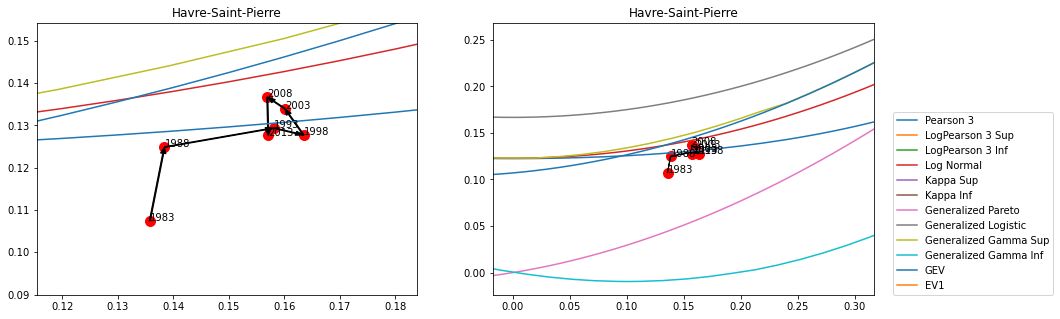

In [109]:
plt.figure(figsize=(15, 5))
Station_name = LSPathStations[stix][:-4]
plt.subplot(122)

for m in maskList:
    dat = DistributionLMR.loc[:, m].dropna()
    Npara = dat.shape[1]
    
    dname = dat.columns[0]
    
    
    if Npara == 2:
        L3 = dat.loc[:, dat.iloc[0, :] == "L3"].iloc[1:].astype("float")
        L4 = dat.loc[:, dat.iloc[0, :] == "L4"].iloc[1:].astype("float")
        plt.plot(L3, L4, label=dname)
        plt.legend()
    else:
        L4inf = dat.loc[:, dat.iloc[0, :] == "L4inf"].iloc[1:].astype("float")
        L4sup = dat.loc[:, dat.iloc[0, :] == "L4SUP"].iloc[1:].astype("float")
        
        L3inf = dat.loc[:, dat.iloc[0, :] == "L3inf"].iloc[1:].astype("float")
        L3sup = dat.loc[:, dat.iloc[0, :] == "L3SUP"].iloc[1:].astype("float")
        
        plt.plot(L3sup, L4sup,label=dname + " Sup" )
        plt.plot(L3inf, L4inf, label=dname + " Inf")
        plt.legend()


        
plt.scatter(LR2, LR3, c="r", s=100)
for i in range(len(LR2)): plt.text(LR2[i], LR3[i], str(Ybeg[i]))  
    
for i in range(len(LR2) - 1):
    xcoor = LR2[i]
    ycoor = LR3[i]
    dx = LR2[i + 1] - LR2[i]
    dy = LR3[i + 1] - LR3[i]
    plt.arrow(xcoor, ycoor, dx, dy,
              width=0.0002, length_includes_head=True,
              head_width=0.001, ec="k", fc="k")

        
   

scale = 15
plt.title(Station_name)
plt.xlim(min(LR2) - scale* np.std(LR2), max(LR2) + scale*np.std(LR2))
plt.ylim(min(LR3) - scale*np.std(LR3), max(LR3) + scale*np.std(LR3))
plt.legend(loc = (1.05,0));


plt.subplot(121)



for m in maskList:
    dat = DistributionLMR.loc[:, m].dropna()
    Npara = dat.shape[1]
    
    dname = dat.columns[0]
    
    
    if Npara == 2:
        L3 = dat.loc[:, dat.iloc[0, :] == "L3"].iloc[1:].astype("float")
        L4 = dat.loc[:, dat.iloc[0, :] == "L4"].iloc[1:].astype("float")
        plt.plot(L3, L4, label=dname)

    else:
        L4inf = dat.loc[:, dat.iloc[0, :] == "L4inf"].iloc[1:].astype("float")
        L4sup = dat.loc[:, dat.iloc[0, :] == "L4SUP"].iloc[1:].astype("float")
        
        L3inf = dat.loc[:, dat.iloc[0, :] == "L3inf"].iloc[1:].astype("float")
        L3sup = dat.loc[:, dat.iloc[0, :] == "L3SUP"].iloc[1:].astype("float")
        
        plt.plot(L3sup, L4sup,label=dname + " Sup" )
        plt.plot(L3inf, L4inf, label=dname + " Inf")


plt.scatter(LR2, LR3, c="r", s=100)
for i in range(len(LR2)): plt.text(LR2[i], LR3[i], str(Ybeg[i]))  
    
for i in range(len(LR2) - 1):
    xcoor = LR2[i]
    ycoor = LR3[i]
    dx = LR2[i + 1] - LR2[i]
    dy = LR3[i + 1] - LR3[i]
    plt.arrow(xcoor, ycoor, dx, dy,
              width=0.0002, length_includes_head=True,
              head_width=0.001, ec="k", fc="k")

scale = 2  
plt.title(Station_name)
plt.xlim(min(LR2) - scale* np.std(LR2), max(LR2) + scale*np.std(LR2))
plt.ylim(min(LR3) - scale*np.std(LR3), max(LR3) + scale*np.std(LR3))
